## Backward Particle Tracking, Refined Grid, Lateral Flow Boundaries

Application of a MODFLOW 6 particle-tracking (PRT) model
to solve example 4 from the MODPATH 7 documentation.

This notebook demonstrates a steady-state MODFLOW 6 simulation
using a quadpatch DISV grid with an irregular domain and a large
number of inactive cells. Particles are tracked backwards from
terminating locations, including a pair of wells in a locally-
refined region of the grid and constant-head cells along the grid's
right side, to release locations along the left border of the grid's
active region. Injection wells along the left-hand border are used
to generate boundary flows.

### Initial setup

Import dependencies, define the example name and workspace,
and read settings from environment variables.

In [1]:
import pathlib as pl
from pprint import pformat

import flopy
import flopy.utils.binaryfile as bf
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flopy.mf6 import MFSimulation
from flopy.plot.styles import styles
from flopy.utils.gridgen import Gridgen
from matplotlib.collections import LineCollection
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-prt-mp7-p04"
# shorten model names so they fit in 16-char limit
gwf_name = sim_name.replace("ex-prt-", "") + "-gwf"
prt_name = sim_name.replace("ex-prt-", "") + "-prt"
mp7_name = sim_name.replace("ex-prt-", "") + "-mp7"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
sim_ws = workspace / sim_name
gwf_ws = sim_ws / "gwf"
prt_ws = sim_ws / "prt"
mp7_ws = sim_ws / "mp7"
gwf_ws.mkdir(exist_ok=True, parents=True)
prt_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

# Define output file names
headfile = f"{gwf_name}.hds"
headfile_bkwd = f"{gwf_name}_bkwd.hds"
budgetfile = f"{gwf_name}.cbb"
budgetfile_bkwd = f"{gwf_name}_bkwd.bud"
trackfile_prt = f"{prt_name}.trk"
trackcsvfile_prt = f"{prt_name}.trk.csv"
budgetfile_prt = f"{prt_name}.cbb"
pathlinefile_mp7 = f"{mp7_name}.mppth"

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

In [3]:
# Model parameters
nper = 1  # Number of periods
nlay = 1  # Numer of layers
nrow = 21  # Number of rows
ncol = 26  # Number of columns
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 100.0  # Top of the model ($ft$)
botm = 0.0  # Layer bottom elevations ($ft$)
kh = 50.0  # Horizontal hydraulic conductivity ($ft/d$)
porosity = 0.1  # Porosity (unitless)

In [4]:
# Time discretization
tdis_rc = [(10000, 1, 1.0)]

In [5]:
# Bottom elevations
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)

[GRIDGEN](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids)
can be used to create a quadpatch grid with a refined region in the upper left quadrant.

We will create a grid with 3 refinement levels, all nearly but not perfectly rectangular:
a 500x500 area is carved out of the corners of the rectangle for each level. To form each
refinement region's polygon we combine 5 rectangles.

First create the top-level grid discretization.

In [6]:
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

# create Gridgen workspace
gridgen_ws = sim_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws=gridgen_ws, exe_name="gridgen")

# add polygon for each refinement level
outer_polygon = [
    [
        (2500, 6000),
        (2500, 9500),
        (3000, 9500),
        (3000, 10000),
        (6000, 10000),
        (6000, 9500),
        (6500, 9500),
        (6500, 6000),
        (6000, 6000),
        (6000, 5500),
        (3000, 5500),
        (3000, 6000),
        (2500, 6000),
    ]
]
g.add_refinement_features([outer_polygon], "polygon", 1, range(nlay))
refshp0 = gridgen_ws / "rf0"

middle_polygon = [
    [
        (3000, 6500),
        (3000, 9000),
        (3500, 9000),
        (3500, 9500),
        (5500, 9500),
        (5500, 9000),
        (6000, 9000),
        (6000, 6500),
        (5500, 6500),
        (5500, 6000),
        (3500, 6000),
        (3500, 6500),
        (3000, 6500),
    ]
]
g.add_refinement_features([middle_polygon], "polygon", 2, range(nlay))
refshp1 = gridgen_ws / "rf1"

inner_polygon = [
    [
        (3500, 7000),
        (3500, 8500),
        (4000, 8500),
        (4000, 9000),
        (5000, 9000),
        (5000, 8500),
        (5500, 8500),
        (5500, 7000),
        (5000, 7000),
        (5000, 6500),
        (4000, 6500),
        (4000, 7000),
        (3500, 7000),
    ]
]
g.add_refinement_features([inner_polygon], "polygon", 3, range(nlay))
refshp2 = gridgen_ws / "rf2"

Build the grid and plot it with refinement levels superimposed.

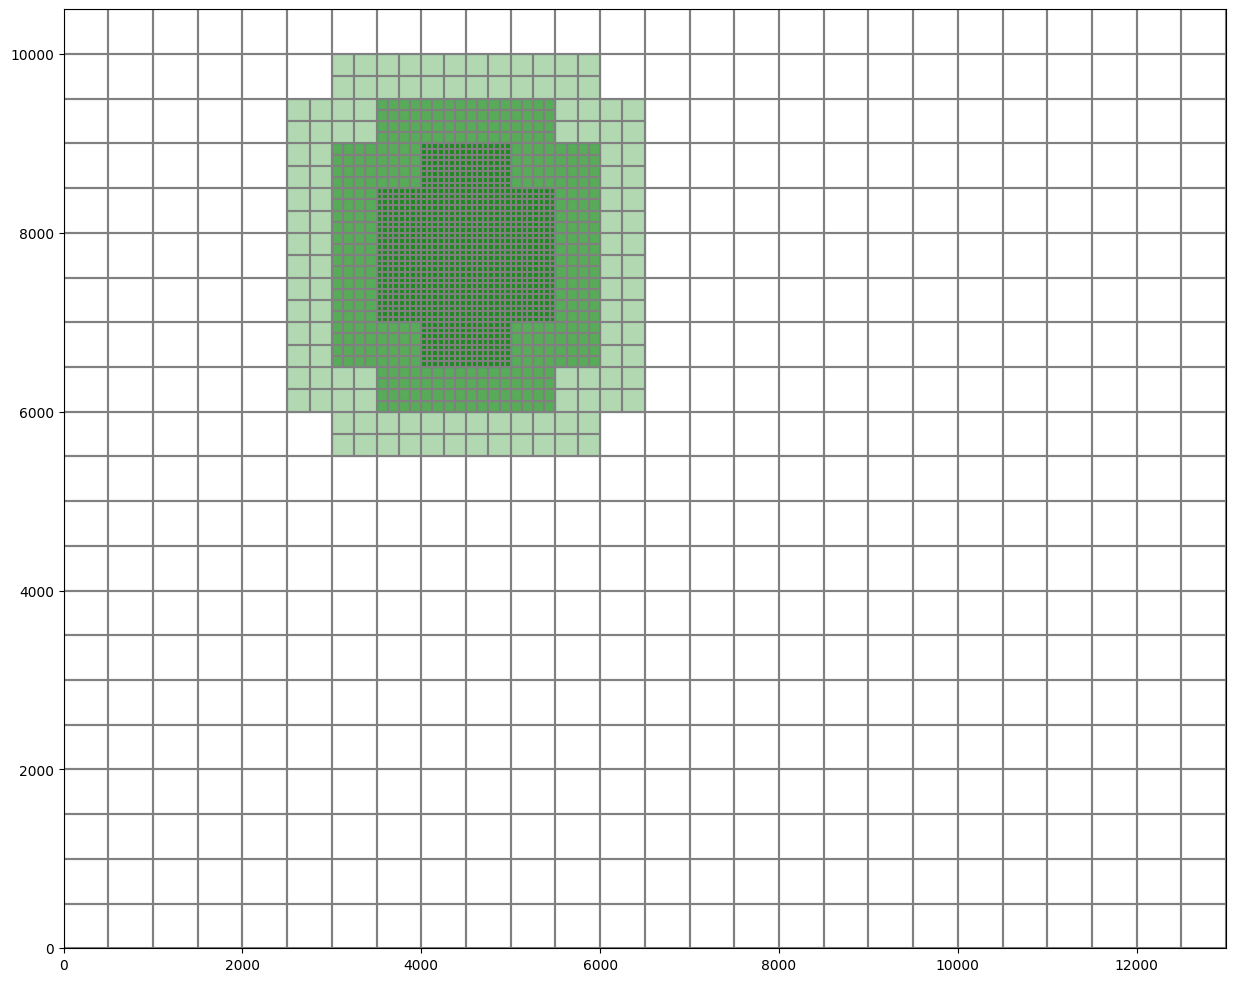

In [7]:
g.build(verbose=False)
grid = flopy.discretization.VertexGrid(**g.get_gridprops_vertexgrid())

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(model=ms)
grid.plot(ax=ax)

flopy.plot.plot_shapefile(refshp0, ax=ax, facecolor="green", alpha=0.3)
flopy.plot.plot_shapefile(refshp1, ax=ax, facecolor="green", alpha=0.5)
flopy.plot.plot_shapefile(str(refshp2), ax=ax, facecolor="green", alpha=0.7)

We are now ready to set up groundwater flow and particle tracking models.

Define shared variables, including discretization parameters, idomain, and porosity.

In [8]:
# fmt: off
idomain = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
    0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0
]
# fmt: on
disv_props = g.get_gridprops_disv()

# from pprint import pprint
# pprint(idomain, compact=True)

Define well locations and flows.

In [9]:
wells = [
    # negative q: discharge
    (0, 861, -30000.0, 0, -1),
    (0, 891, -30000.0, 0, -1),
    # positive q: injection
    (0, 1959, 10000.0, 1, 4),
    (0, 1932, 10000.0, 3, 3),
    (0, 1931, 10000.0, 3, 3),
    (0, 1930, 5000.0, 1, 4),
    (0, 1930, 5000.0, 3, 3),
    (0, 1903, 5000.0, 1, 4),
    (0, 1903, 5000.0, 3, 3),
    (0, 1876, 10000.0, 3, 3),
    (0, 1875, 10000.0, 3, 3),
    (0, 1874, 5000.0, 1, 4),
    (0, 1874, 5000.0, 3, 3),
    (0, 1847, 10000.0, 3, 3),
    (0, 1846, 10000.0, 3, 3),
    (0, 1845, 5000.0, 1, 4),
    (0, 1845, 5000.0, 3, 3),
    (0, 1818, 5000.0, 1, 4),
    (0, 1818, 5000.0, 3, 3),
    (0, 1792, 10000.0, 1, 4),
    (0, 1766, 10000.0, 1, 4),
    (0, 1740, 5000.0, 1, 4),
    (0, 1740, 5000.0, 4, 1),
    (0, 1715, 5000.0, 1, 4),
    (0, 1715, 5000.0, 4, 1),
    (0, 1690, 10000.0, 1, 4),
    (0, 1646, 5000.0, 1, 4),
    (0, 1646, 5000.0, 4, 1),
    (0, 1549, 5000.0, 1, 4),
    (0, 1549, 5000.0, 4, 1),
    (0, 1332, 5000.0, 4, 1),
    (0, 1332, 5000.0, 1, 5),
    (0, 1021, 2500.0, 1, 4),
    (0, 1021, 2500.0, 4, 1),
    (0, 1020, 5000.0, 1, 5),
    (0, 708, 2500.0, 1, 5),
    (0, 708, 2500.0, 4, 1),
    (0, 711, 625.0, 1, 4),
    (0, 711, 625.0, 4, 1),
    (0, 710, 625.0, 1, 4),
    (0, 710, 625.0, 4, 1),
    (0, 409, 1250.0, 1, 4),
    (0, 407, 625.0, 1, 4),
    (0, 407, 625.0, 4, 1),
    (0, 402, 625.0, 1, 5),
    (0, 402, 625.0, 4, 1),
    (0, 413, 1250.0, 1, 4),
    (0, 411, 1250.0, 1, 4),
    (0, 203, 1250.0, 1, 5),
    (0, 203, 1250.0, 4, 1),
    (0, 202, 1250.0, 1, 4),
    (0, 202, 1250.0, 4, 1),
    (0, 199, 2500.0, 1, 4),
    (0, 197, 1250.0, 1, 4),
    (0, 197, 1250.0, 4, 1),
    (0, 96, 2500.0, 1, 4),
    (0, 96, 2500.0, 4, 1),
    (0, 98, 1250.0, 1, 4),
    (0, 101, 1250.0, 1, 4),
    (0, 101, 1250.0, 4, 1),
    (0, 100, 1250.0, 1, 4),
    (0, 100, 1250.0, 4, 1),
    (0, 43, 2500.0, 1, 5),
    (0, 43, 2500.0, 4, 1),
    (0, 44, 2500.0, 1, 4),
    (0, 44, 2500.0, 4, 1),
    (0, 45, 5000.0, 4, 1),
    (0, 10, 10000.0, 1, 5),
]

assert len(wells) == 68

# Define particle release locations, initially in the
# representation for MODPATH 7 particle input style 1.
particles = [
    # MODPATH 7 input style 1
    # (node number, localx, localy, localz)
    (1327, 0.000, 0.125, 0.500),
    (1327, 0.000, 0.375, 0.500),
    (1327, 0.000, 0.625, 0.500),
    (1327, 0.000, 0.875, 0.500),
    (1545, 0.000, 0.125, 0.500),
    (1545, 0.000, 0.375, 0.500),
    (1545, 0.000, 0.625, 0.500),
    (1545, 0.000, 0.875, 0.500),
    (1643, 0.000, 0.125, 0.500),
    (1643, 0.000, 0.375, 0.500),
    (1643, 0.000, 0.625, 0.500),
    (1643, 0.000, 0.875, 0.500),
    (1687, 0.000, 0.125, 0.500),
    (1687, 0.000, 0.375, 0.500),
    (1687, 0.000, 0.625, 0.500),
    (1687, 0.000, 0.875, 0.500),
    (1713, 0.000, 0.125, 0.500),
    (1713, 0.000, 0.375, 0.500),
    (1713, 0.000, 0.625, 0.500),
    (1713, 0.000, 0.875, 0.500),
    (861, 0.000, 0.125, 0.500),
    (861, 0.000, 0.375, 0.500),
    (861, 0.000, 0.625, 0.500),
    (861, 0.000, 0.875, 0.500),
    (861, 1.000, 0.125, 0.500),
    (861, 1.000, 0.375, 0.500),
    (861, 1.000, 0.625, 0.500),
    (861, 1.000, 0.875, 0.500),
    (861, 0.125, 0.000, 0.500),
    (861, 0.375, 0.000, 0.500),
    (861, 0.625, 0.000, 0.500),
    (861, 0.875, 0.000, 0.500),
    (861, 0.125, 1.000, 0.500),
    (861, 0.375, 1.000, 0.500),
    (861, 0.625, 1.000, 0.500),
    (861, 0.875, 1.000, 0.500),
    (891, 0.000, 0.125, 0.500),
    (891, 0.000, 0.375, 0.500),
    (891, 0.000, 0.625, 0.500),
    (891, 0.000, 0.875, 0.500),
    (891, 1.000, 0.125, 0.500),
    (891, 1.000, 0.375, 0.500),
    (891, 1.000, 0.625, 0.500),
    (891, 1.000, 0.875, 0.500),
    (891, 0.125, 0.000, 0.500),
    (891, 0.375, 0.000, 0.500),
    (891, 0.625, 0.000, 0.500),
    (891, 0.875, 0.000, 0.500),
    (891, 0.125, 1.000, 0.500),
    (891, 0.375, 1.000, 0.500),
    (891, 0.625, 1.000, 0.500),
    (891, 0.875, 1.000, 0.500),
]

# For vertex grids, the MODFLOW 6 PRT model's PRP (particle release point) package expects initial
# particle locations as tuples `(particle ID, (layer, cell ID), x coord, y coord, z coord)`. While
# MODPATH 7 input style 1 expects local coordinates, PRT expects global coordinates (the user must
# guarantee that each release point's coordinates fall within the cell with the given ID). FloPy's
# `ParticleData` class provides a `to_coords()` utility method to convert local coordinates to
# global coordinates for easier migration from MODPATH 7 to PRT.
partdata = flopy.modpath.ParticleData(
    partlocs=[p[0] for p in particles],
    structured=False,
    localx=[p[1] for p in particles],
    localy=[p[2] for p in particles],
    localz=[p[3] for p in particles],
    timeoffset=0,
    drape=0,
)
# coords = partdata.to_coords(grid)
# particles_prt = [
#     (i, (0, p[0]), c[0], c[1], c[2]) for i, (p, c) in enumerate(zip(particles, coords))
# ]
particles_prt = list(partdata.to_prp(grid))

### Model setup

Define functions to build models, write input files, and run the simulation.

In [10]:


def build_gwf():
    print("Building GWF model")

    # simulation
    sim = flopy.mf6.MFSimulation(
        sim_name=gwf_name, sim_ws=gwf_ws, exe_name="mf6", version="mf6"
    )

    # temporal discretization
    tdis = flopy.mf6.ModflowTdis(
        sim, time_units=time_units, nper=len(tdis_rc), perioddata=tdis_rc
    )

    # iterative model solver
    ims = flopy.mf6.ModflowIms(
        sim,
        pname="ims",
        complexity="SIMPLE",
        outer_dvclose=1e-4,
        outer_maximum=100,
        inner_dvclose=1e-5,
        under_relaxation_theta=0,
        under_relaxation_kappa=0,
        under_relaxation_gamma=0,
        under_relaxation_momentum=0,
        linear_acceleration="BICGSTAB",
        relaxation_factor=0.99,
        number_orthogonalizations=2,
    )

    # groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=gwf_name, model_nam_file=f"{sim_name}.nam", save_flows=True
    )

    # grid discretization
    disv = flopy.mf6.ModflowGwfdisv(
        gwf, length_units=length_units, idomain=idomain, **disv_props
    )

    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=150.0)

    flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf,
        maxbound=len(wells),
        auxiliary=["IFACE", "IFLOWFACE"],
        save_flows=True,
        stress_period_data={0: wells},
    )

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        xt3doptions=True,
        save_flows=True,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=[0],
        k=[kh],
    )

    # constant head boundary (period, node number, head)
    chd_bound = [
        (0, 1327, 150.0),
        (0, 1545, 150.0),
        (0, 1643, 150.0),
        (0, 1687, 150.0),
        (0, 1713, 150.0),
    ]
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        pname="chd",
        save_flows=True,
        stress_period_data=chd_bound,
        # auxiliary=["IFLOWFACE"]
    )

    # output control
    budget_file = f"{gwf_name}.cbb"
    head_file = f"{gwf_name}.hds"
    oc = flopy.mf6.ModflowGwfoc(
        gwf,
        pname="oc",
        budget_filerecord=[budget_file],
        head_filerecord=[head_file],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    return sim


def build_prt():
    print("Building PRT model")

    simprt = flopy.mf6.MFSimulation(
        sim_name=prt_name, version="mf6", exe_name="mf6", sim_ws=prt_ws
    )

    flopy.mf6.ModflowTdis(
        simprt, pname="tdis", time_units="DAYS", nper=len(tdis_rc), perioddata=tdis_rc
    )

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        simprt, modelname=prt_name, model_nam_file=f"{prt_name}.nam"
    )

    # Instantiate the MODFLOW 6 DISV vertex grid discretization
    disv = flopy.mf6.ModflowGwfdisv(prt, idomain=idomain, **disv_props)

    # Instantiate the MODFLOW 6 prt model input package
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp",
        filename=f"{prt_name}_4.prp",
        nreleasepts=len(particles_prt),
        packagedata=particles_prt,
        perioddata={0: ["FIRST"]},
        exit_solve_tolerance=1e-5,
        extend_tracking=True,
    )

    # Instantiate the MODFLOW 6 prt output control package
    budgetfile_prt = f"{prt_name}.cbb"
    budget_record = [budgetfile_prt]
    trackfile_prt = f"{prt_name}.trk"
    trackcsvfile_prt = f"{prt_name}.trk.csv"
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        track_filerecord=trackfile_prt,
        trackcsv_filerecord=trackcsvfile_prt,
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    flopy.mf6.ModflowPrtfmi(
        prt,
        packagedata=[
            ("GWFHEAD", pl.Path(f"../{gwf_ws.name}/{headfile_bkwd}")),
            ("GWFBUDGET", pl.Path(f"../{gwf_ws.name}/{budgetfile_bkwd}")),
        ],
    )

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        simprt,
        pname="ems",
        filename=f"{prt_name}.ems",
    )
    simprt.register_solution_package(ems, [prt.name])

    return simprt


def build_mp7(gwf):
    print("Building MP7 model")

    pg = flopy.modpath.ParticleGroup(
        particlegroupname="G1", particledata=partdata, filename=f"{sim_name}.sloc"
    )

    mp = flopy.modpath.Modpath7(
        modelname=mp7_name,
        flowmodel=gwf,
        exe_name="mp7",
        model_ws=mp7_ws,
    )
    mpbas = flopy.modpath.Modpath7Bas(mp, porosity=porosity)
    mpsim = flopy.modpath.Modpath7Sim(
        mp,
        simulationtype="pathline",
        trackingdirection="backward",
        budgetoutputoption="summary",
        particlegroups=[pg],
    )

    return mp


def build_models():
    gwfsim = build_gwf()
    gwf = gwfsim.get_model(gwf_name)
    prtsim = build_prt()
    mp7sim = build_mp7(gwf)
    return gwfsim, prtsim, mp7sim


def reverse_budgetfile(fpth, rev_fpth, tdis):
    f = bf.CellBudgetFile(fpth, tdis=tdis)
    f.reverse(rev_fpth)


def reverse_headfile(fpth, rev_fpth, tdis):
    f = bf.HeadFile(fpth, tdis=tdis)
    f.reverse(rev_fpth)


def write_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            sim.write_simulation(silent=silent)
        else:
            sim.write_input()


@timed
def run_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            success, buff = sim.run_simulation(silent=silent, report=True)
        else:
            success, buff = sim.run_model(silent=silent, report=True)
        assert success, pformat(buff)

        if "gwf" in sim.name:
            # Reverse budget and head files for backward tracking
            reverse_budgetfile(gwf_ws / budgetfile, gwf_ws / budgetfile_bkwd, sim.tdis)
            reverse_headfile(gwf_ws / headfile, gwf_ws / headfile_bkwd, sim.tdis)

### Plotting results

Define functions to plot the grid, boundary conditions, and model results.

Below we highlight the vertices of well-containing cells which lie on the boundary between
coarser- and finer-grained refinement regions (there are 7 of these). Note the disagreement
between values of MODFLOW 6 PRT's `IFLOWFACE` and MODPATH 7's `IFACE` for these cells. This
is because the cells have 5 polygonal faces.

In [11]:


def sort_square_verts(verts):
    """Sort 4 or more points on a square in clockwise order, starting with the top-left point"""

    # sort by y coordinate
    verts.sort(key=lambda v: v[1], reverse=True)

    # separate top and bottom rows
    y0 = verts[0][1]
    t = [v for v in verts if v[1] == y0]
    b = verts[len(t) :]

    # sort top and bottom rows by x coordinate
    t.sort(key=lambda v: v[0])
    b.sort(key=lambda v: v[0])

    # return vertices in clockwise order
    return t + list(reversed(b))


def plot_well_cell_ids(ax):
    xc, yc = grid.get_xcellcenters_for_layer(0), grid.get_ycellcenters_for_layer(0)
    for well in wells:
        nn = well[1]
        x, y = xc[nn], yc[nn]
        ax.annotate(str(nn), (x - 50, y - 50), color="purple")


cells_on_refinement_boundary = [10, 43, 203, 402, 708, 1020, 1332]


def plot_well_vertices_on_refinement_boundary(ax):
    for nn in cells_on_refinement_boundary:
        verts = list(set([tuple(grid.verts[v]) for v in grid.iverts[nn]]))
        verts = [
            v
            for v in verts
            if len([vv for vv in verts if vv[0] == v[0]]) > 2
            or len([vv for vv in verts if vv[1] == v[1]]) > 2
        ]
        for v in verts:
            ax.plot(v[0], v[1], "go", ms=3)


def plot_well_ifaces(ax):
    ifaces = []
    for well in wells:
        nn = well[1]
        iverts = grid.iverts[nn]

        # sort vertices of well cell in clockwise order
        verts = [tuple(grid.verts[v]) for v in iverts]
        sorted_verts = sort_square_verts(list(set(verts.copy())))

        # reduce vertices to 4 corners of square
        xmax, xmin = (
            max([v[0] for v in sorted_verts]),
            min([v[0] for v in sorted_verts]),
        )
        ymax, ymin = (
            max([v[1] for v in sorted_verts]),
            min([v[1] for v in sorted_verts]),
        )
        sorted_verts = [
            v for v in sorted_verts if v[0] in [xmax, xmin] and v[1] in [ymax, ymin]
        ]

        # define the iface line segment
        iface = well[3]
        if iface == 1:
            p0 = sorted_verts[0]
            p1 = sorted_verts[-1]
        elif iface == 2:
            p0 = sorted_verts[1]
            p1 = sorted_verts[2]
        elif iface == 3:
            p0 = sorted_verts[2]
            p1 = sorted_verts[3]
        elif iface == 4:
            p0 = sorted_verts[0]
            p1 = sorted_verts[1]
        else:
            continue

        ifaces.append([p0, p1])

    lc = LineCollection(ifaces, color="red", lw=4)
    ax.add_collection(lc)


def plot_map_view(ax, gwf):
    # plot map view of grid
    mv = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mv.plot_grid(alpha=0.3)
    mv.plot_ibound()  # inactive cells
    mv.plot_bc("WEL", alpha=0.3)  # wells (red)
    ax.add_patch(  # constant head boundary (blue)
        mpl.patches.Rectangle(
            ((ncol - 1) * delc, (nrow - 6) * delr),
            1000,
            -2500,
            linewidth=5,
            facecolor="blue",
            alpha=0.5,
        )
    )


def plot_inset(ax, gwf):
    # create inset
    axins = ax.inset_axes([-0.75, 0.35, 0.6, 0.8])

    # plot grid features
    plot_map_view(axins, gwf)
    plot_well_ifaces(axins)
    plot_well_vertices_on_refinement_boundary(axins)

    # zoom in on refined region of injection well boundary
    axins.set_xlim(2000, 6000)
    axins.set_ylim(6000, 10500)

    # add legend
    legend_elements = [
        mpl.lines.Line2D(
            [0],
            [0],
            color="red",
            lw=4,
            label="Well cell faces assigned flow (IFLOWFACE)",
        ),
        mpl.lines.Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            label="Well cell vertices on refinement border",
            markerfacecolor="g",
            markersize=15,
        ),
    ]
    axins.legend(handles=legend_elements, bbox_to_anchor=(0.33, -0.2, 0.8, 0.1))

    # add the inset
    ax.indicate_inset_zoom(axins)


def plot_grid(gwf, title=None):
    with styles.USGSPlot():
        # setup the plot
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        if title is not None:
            styles.heading(ax=ax, heading=title)

        # add plot features
        plot_map_view(ax, gwf)
        plot_well_ifaces(ax)
        plot_inset(ax, gwf)

        # add legend
        ax.legend(
            handles=[
                mpl.patches.Patch(color="red", label="Wells", alpha=0.3),
                mpl.patches.Patch(color="blue", label="Constant-head boundary"),
            ],
            bbox_to_anchor=(-1.1, 0, 0.8, 0.1),
        )

        plt.subplots_adjust(left=0.43)

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-grid")

In [12]:
def plot_pathlines(ax, grid, hd, pl, title=None):
    ax.set_aspect("equal")
    if title is not None:
        ax.set_title(title)
    mm = flopy.plot.PlotMapView(modelgrid=grid, ax=ax)
    mm.plot_grid(lw=0.5, alpha=0.5)
    mm.plot_ibound()
    pc = mm.plot_array(hd, edgecolor="black", alpha=0.5)
    cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
    cb.ax.set_xlabel(r"Head ($ft$)")
    mm.plot_pathline(pl, layer="all", lw=0.3, colors=["black"])


def plot_all_pathlines(grid, heads, prtpl, mp7pl=None, title=None):
    with styles.USGSPlot():
        fig, ax = plt.subplots(ncols=1 if mp7pl is None else 2, nrows=1, figsize=(7, 7))
        if title is not None:
            styles.heading(ax=ax, heading=title)

        plot_pathlines(
            ax if mp7pl is None else ax[0],
            grid,
            heads,
            prtpl,
            None if mp7pl is None else "MODFLOW 6 PRT",
        )
        if mp7pl is not None:
            plot_pathlines(ax[1], grid, heads, mp7pl, "MODPATH 7")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-paths")


def plot_all(gwf):
    # extract grid
    grid = gwf.modelgrid

    # load mf6 gwf head results
    hf = flopy.utils.HeadFile(gwf_ws / headfile)
    hds = hf.get_data()

    # load mf6 prt pathline results
    prt_pl = pd.read_csv(prt_ws / trackcsvfile_prt)

    # load mp7 pathline results
    plf = flopy.utils.PathlineFile(mp7_ws / pathlinefile_mp7)
    mp7_pl = pd.DataFrame(
        plf.get_destination_pathline_data(range(grid.nnodes), to_recarray=True)
    )

    plot_grid(gwf, title="Model grid and boundary conditions")
    plot_all_pathlines(grid, hds, prt_pl, title="Head and pathlines")

### Running the example

Define a function to run the example scenarios and plot results.

Building GWF model
Building PRT model
Building MP7 model
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model mp7-p04-gwf...
    writing model name file...
    writing package disv...


    writing package ic...
    writing package wel_0...
    writing package npf...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 5 based on size of stress_period_data
    writing package oc...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model mp7-p04-prt...
    writing model name file...
    writing package disv...
    writing package mip...
    writing package prp...
    writing package oc...


    writing package fmi...
FloPy is using the following executable to run the model: ../../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/07/2025
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Feb  8 2025 12:33:09 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages

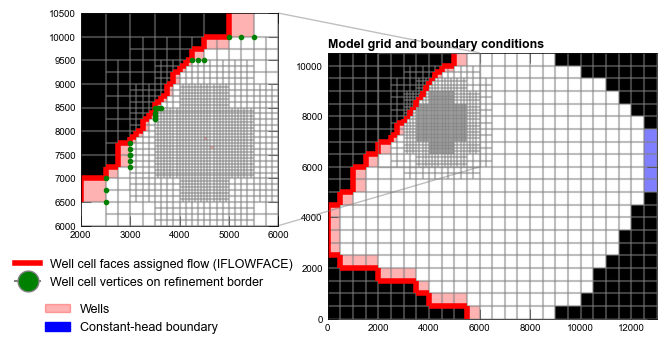

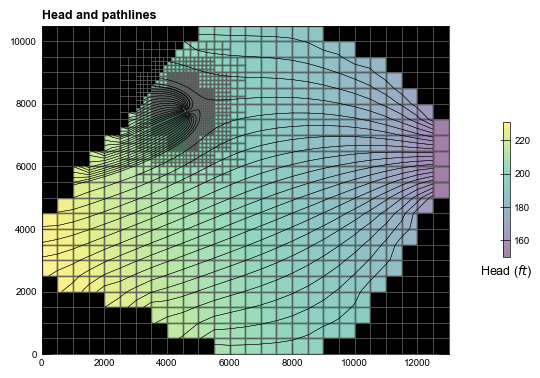

In [13]:


def scenario(silent=False):
    gwfsim, prtsim, mp7sim = build_models()
    if write:
        write_models(gwfsim, prtsim, mp7sim, silent=silent)
    if run:
        run_models(gwfsim, prtsim, mp7sim, silent=silent)
    if plot:
        gwf = gwfsim.get_model(gwf_name)

        plot_all(gwf)


# Now run the scenario for example problem 4.
scenario(silent=False)
